# Different ML methods

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install tensorflow
!pip install lightgbm==3.3.5

import torch
print(torch.__version__)  # check pytorch version
print(torch.cuda.is_available())  # check disponibility GPU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.6 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=390938 sha256=225c3c77d0f64f70c5d1ce2b1267009cdc0407756a863fd7d4ee470dd1cd6498
  Stored in directory: /tmp/pip-ephem-wheel-cache-r68qsaw0/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e859a949367ba842577b
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=b6e3fff3b0dba80d91b2e6a8a586e8fa63e011b19500f38cb88ccef87b9ae5b8
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb3

## **Data**


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import math as math
from google.colab import drive
from pandas_profiling import ProfileReport
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib
from joblib import dump
import random

drive.mount('/content/drive')

# read data from google drive
data1 = pd.read_excel('/content/drive/MyDrive/TEST1.5_ALINEADOS.xlsx')
data2 = pd.read_excel('/content/drive/MyDrive/TEST2.0_ALINEADOS.xlsx')
data3 = pd.read_excel('/content/drive/MyDrive/TESTNUEVOMOV1.1_ALINEADOS.xlsx')
data4 = pd.read_excel('/content/drive/MyDrive/TESTNUEVOMOV2.1_ALINEADOS_quitandoultimo.xlsx')

# combine datasets
data_train = pd.concat([data1, data2, data3, data4], ignore_index=True)

# Degrees to radians
data_train['RotationX_rad'] = np.radians(data_train['RotationX_deg'])
data_train['RotationZ_rad'] = np.radians(data_train['RotationZ_deg'])

# Pitch and Yaw to Inclination and Orientation
data_train['Inclination_mocap_deg'] = np.sqrt(data_train['RotationX_deg']**2 + data_train['RotationZ_deg']**2) #YAW = ROTX // PITCH = ROTZ
data_train['Orientation_mocap_deg'] = np.degrees(np.arctan2(data_train['RotationZ_rad'], - data_train['RotationX_rad'])) % 360
data_train.to_excel('/content/drive/MyDrive/data_train_completo.xlsx', index=False)

print(data_train.shape)
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)

<ipython-input-2-2f84dc49b57a>:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(47208, 19)
(14000, 15)
(15600, 15)
(13000, 15)
(4608, 15)


In [ ]:
data_train

Time  Inclination_deg  Orientation_deg  Pitch_rad       Yaw_rad  \
0       0.00                5               90   0.087266 -5.343530e-18   
1       0.01                5               90   0.087266 -5.343530e-18   
2       0.02                5               90   0.087266 -5.343530e-18   
3       0.03                5               90   0.087266 -5.343530e-18   
4       0.04                5               90   0.087266 -5.343530e-18   
...      ...              ...              ...        ...           ...   
47203  46.03                0                0   0.000000  0.000000e+00   
47204  46.04                0                0   0.000000  0.000000e+00   
47205  46.05                0                0   0.000000  0.000000e+00   
47206  46.06                0                0   0.000000  0.000000e+00   
47207  46.07                0                0   0.000000  0.000000e+00   

       Pitch_deg       Yaw_deg  Motor7_rad  Motor8_rad  RotationX_deg  \
0            5.0 -3.061617e-16    0.000037   -0.001193       0.008419   
1            5.0 -3.061617e-16   -0.001044   -0.002061      -0.003308   
2            5.0 -3.061617e-16   -0.004490   -0.005720      -0.005990   
3            5.0 -3.061617e-16   -0.009364   -0.008991      -0.035353   
4            5.0 -3.061617e-16   -0.013859   -0.013838      -0.095634   
...          ...           ...         ...         ...            ...   
47203        0.0  0.000000e+00    0.648698    0.273320      14.711147   
47204        0.0  0.000000e+00    0.646573    0.271355      14.709536   
47205        0.0  0.000000e+00    0.644432    0.269757      14.701248   
47206        0.0  0.000000e+00    0.641460    0.266002      14.702192   
47207        0.0  0.000000e+00    0.636682    0.262614      14.703637   

       RotationY_deg  RotationZ_deg  PositionX_cm  PositionY_cm  PositionZ_cm  \
0          -0.013648       0.029721      0.016005      0.039895     -0.107521   
1           0.039036       0.066985      0.011164      0.040308     -0.108233   
2           0.011233       0.096144      0.005485      0.039643     -0.108597   
3          -0.006483       0.147246     -0.000995      0.039561     -0.109620   
4           0.020651       0.200617     -0.006932      0.039068     -0.114155   
...              ...            ...           ...           ...           ...   
47203       1.400843      -7.196888      0.670360     -0.174755      1.914952   
47204       1.403313      -7.186175      0.670447     -0.175137      1.915329   
47205       1.413039      -7.194132      0.671008     -0.175468      1.915061   
47206       1.408652      -7.198619      0.671317     -0.175357      1.914986   
47207       1.408077      -7.191154      0.671489     -0.175158      1.915067   

       RotationX_rad  RotationZ_rad  Inclination_mocap_deg  \
0           0.000147       0.000519               0.030891   
1          -0.000058       0.001169               0.067066   
2          -0.000105       0.001678               0.096330   
3          -0.000617       0.002570               0.151431   
4          -0.001669       0.003501               0.222246   
...              ...            ...                    ...   
47203       0.256758      -0.125609              16.377212   
47204       0.256730      -0.125422              16.371058   
47205       0.256585      -0.125561              16.367108   
47206       0.256602      -0.125640              16.369929   
47207       0.256627      -0.125509              16.367945   

       Orientation_mocap_deg  
0                 105.815026  
1                  87.173003  
2                  86.434860  
3                  76.499081  
4                  64.512930  
...                      ...  
47203             206.068492  
47204             206.037290  
47205             206.075055  
47206             206.087708  
47207             206.062016  

[47208 rows x 19 columns]

### Data analysis

In [ ]:
# data analysis
profile = data_train.profile_report(title='Finger Report')
profile.to_file("FingerAnalysis.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Columns selection

In [ ]:
# DATASET
# select the columns needed
#print(data.columns)
data_a = data_train[['RotationX_rad', 'RotationZ_rad', 'Motor7_rad', 'Motor8_rad']] # inputs, outputs in radians

df_train = pd.DataFrame(data_a)
print(df_train.head())
print(df_train.shape)

   RotationX_rad  RotationZ_rad  Motor7_rad  Motor8_rad
0       0.000147       0.000519    0.000037   -0.001193
1      -0.000058       0.001169   -0.001044   -0.002061
2      -0.000105       0.001678   -0.004490   -0.005720
3      -0.000617       0.002570   -0.009364   -0.008991
4      -0.001669       0.003501   -0.013859   -0.013838
(47208, 4)


In [ ]:
#outputs
print(data_a["Motor8_rad"].describe())
print(data_a["Motor7_rad"].describe())
#inputs
print(data_a['RotationX_rad'].describe())
print(data_a['RotationZ_rad'].describe())

count    47208.000000
mean        -0.154757
std          0.247496
min         -0.758585
25%         -0.325866
50%         -0.108630
75%          0.000016
max          0.364579
Name: Motor8_rad, dtype: float64
count    47208.000000
mean         0.166756
std          0.247058
min         -0.357540
25%         -0.000149
50%          0.122860
75%          0.340899
max          0.765616
Name: Motor7_rad, dtype: float64
count    47208.000000
mean         0.091690
std          0.086937
min         -0.016445
25%          0.016829
50%          0.059234
75%          0.156029
max          0.312632
Name: RotationX_rad, dtype: float64
count    47208.000000
mean         0.053400
std          0.113419
min         -0.143431
25%         -0.021265
50%          0.024068
75%          0.121257
max          0.391076
Name: RotationZ_rad, dtype: float64


### Suffle the data and separate in train and test

In [ ]:
import sklearn.utils
data = sklearn.utils.shuffle(df_train)

#separate data in train and test
x = data.iloc[:,:2] # two first columns inputs
y = data.iloc[:,2:] # two last columns outputs
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_test_plot = y_test.copy()

#NORMALIZE
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train.astype('float32'))
X_test = scaler.transform(X_test.astype('float32'))

#******************************************************************************

# #to save the models with all train
# x = data.iloc[:,:2] # two first columns inputs
# y_train = data.iloc[:,2:] # two last columns outputs

# #NORMALIZE
# scaler = MinMaxScaler(feature_range=(-1, 1))
# X_train = scaler.fit_transform(x.astype('float32'))

# verify shapes
print('Training dataset (input) shape: ', X_train.shape)
print('Test dataset (input) shape: ', X_test.shape)
print('Training dataset (output) shape: ', y_train.shape)
print('Test dataset (output) shape: ', y_test.shape)
X_test

Training dataset (input) shape:  (37766, 2)
Test dataset (input) shape:  (9442, 2)
Training dataset (output) shape:  (37766, 2)
Test dataset (output) shape:  (9442, 2)


array([[-0.6857331 , -0.23943625],
       [-0.22201228,  0.62823135],
       [-0.22997385, -0.4343611 ],
       ...,
       [-0.71892357, -0.42018673],
       [-0.41049415,  0.40143788],
       [-0.8957517 , -0.3966232 ]], dtype=float32)

## **Functions**

### Function to calculate the errors

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_errors(y_test, y_pred):
  # Asegurarse de que son arrays bidimensionales
  y_test_array = np.array(y_test)
  y_pred_array = np.array(y_pred)

  # Separar los valores reales y las predicciones para cada motor
  y_test_motor7 = y_test_array[:,0]  # Columna para motor 7
  y_test_motor8 = y_test_array[:,1]  # Columna para motor 8

  y_pred_motor7 = y_pred_array[:,0]  # Predicciones para motor 7
  y_pred_motor8 = y_pred_array[:,1]  # Predicciones para motor 8

  # Funciones para NRMSE y NMAE
  def nrmse(y_true, y_pred):
      nrmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
      return nrmse / (np.max(y_true) - np.min(y_true))

  def nmae(y_true, y_pred):
      mae = np.mean(np.abs(y_true - y_pred))
      return mae / (np.max(y_true) - np.min(y_true))

  # Funcion para RAE
  def rae(y_true, y_pred):
      y_test_mean=np.mean(y_true)
      rae=np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true-y_test_mean))
      return rae

  # Funcion para MSLE
  def msle(y_true, y_pred):
      msle=np.mean((np.log1p(y_true)-np.log1p(y_pred))**2)
      return msle

  # Calcular los errores para el motor 7
  mse_motor7 = mean_squared_error(y_test_motor7, y_pred_motor7)
  r2_motor7 = r2_score(y_test_motor7, y_pred_motor7)
  nrmse_motor7 = nrmse(y_test_motor7, y_pred_motor7)
  nmae_motor7 = nmae(y_test_motor7, y_pred_motor7)
  rae_motor7 = rae(y_test_motor7, y_pred_motor7)
  msle_motor7 = msle(y_test_motor7, y_pred_motor7)

  # Calcular los errores para el motor 8
  mse_motor8 = mean_squared_error(y_test_motor8, y_pred_motor8)
  r2_motor8 = r2_score(y_test_motor8, y_pred_motor8)
  nrmse_motor8 = nrmse(y_test_motor8, y_pred_motor8)
  nmae_motor8 = nmae(y_test_motor8, y_pred_motor8)
  rae_motor8 = rae(y_test_motor8, y_pred_motor8)
  msle_motor8 = msle(y_test_motor8, y_pred_motor8)

  return mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8

### Function to plot the motors vs time




In [ ]:
import plotly.graph_objects as go

def create_scatter_plot(df, motor_pred_col, motor_actual_col, motor_name, title):
    fig = go.Figure()

    # Add predicted data
    fig.add_trace(go.Scatter(
        x=df['time'],
        y=df[motor_pred_col],
        mode='markers',
        marker=dict(size=8, color='blue', opacity=0.8),
        name=f'{motor_name}_pred',
        hovertemplate=f'Time: %{{x}}<br>{motor_name}_pred: %{{y}}'
    ))

    # Add actual data
    fig.add_trace(go.Scatter(
        x=df['time'],
        y=df[motor_actual_col],
        mode='markers',
        marker=dict(size=8, color='red', opacity=0.8),
        name=f'{motor_name}',
        hovertemplate=f'Time: %{{x}}<br>{motor_name}: %{{y}}'
    ))

    # Customize the layout
    fig.update_layout(
        title=title,
        xaxis_title='Time',
        yaxis_title=motor_name,
        showlegend=True,
        legend=dict(x=0.8, y=1),
        margin=dict(l=0, r=0, t=20, b=20),
        plot_bgcolor='white'
    )

    # Remove the top and right spines
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

    # Show the plot
    fig.show()

### Function to plot dispersion

In [ ]:
def create_comparison_scatter_plot(df, real_col, pred_col, motor_name, title):
    """
    Crea un gráfico de dispersión para comparar valores reales y predichos.
    """
    fig = go.Figure()

    # Scatter plot para los valores reales
    fig.add_trace(go.Scatter(
        x=df[real_col],
        y=df[real_col],
        mode='markers',
        marker=dict(size=8, color='blue', opacity=0.8),
        name=f'{motor_name}_real',
        hovertemplate=f'{motor_name}_real: %{{x}}'
    ))

    # Scatter plot para los valores predichos
    fig.add_trace(go.Scatter(
        x=df[real_col],
        y=df[pred_col],
        mode='markers',
        marker=dict(size=8, color='red', opacity=0.8),
        name=f'{motor_name}_pred',
        hovertemplate=f'{motor_name}_real: %{{x}}<br>{motor_name}_pred: %{{y}}'
    ))

    # Personalizar el diseño
    fig.update_layout(
        title=title,
        xaxis_title=f'{motor_name}_real',
        yaxis_title=f'{motor_name}_pred',
        showlegend=True,
        legend=dict(x=0.8, y=1),
        margin=dict(l=0, r=0, t=20, b=20),
        plot_bgcolor='white'
    )

    # Configuración de los ejes
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

    # Mostrar el gráfico
    fig.show()

### Early Stopping Configuration

In [ ]:
# Configuración de EarlyStopping
early_stopping = EarlyStopping(
    monitor='accuracy',         # Monitoriza la exactitud
    patience=7,                 # Si no hay mejora en 7 épocas, detiene el entrenamiento
    min_delta=0.0001,            # Requiere una mejora mínima de 0.0001 en accuracy para continuar
    restore_best_weights=True   # Restaura los mejores pesos
)

## **Light Gradient Boosting**

In [ ]:
#Gradient Boosting Regressor (XGBoost, LightGBM)
# Create LightGBM model
model = lgb.LGBMRegressor()

# Create MultiOutputRegressor with the LightGBM model to train with multiple outputs
multi_model = MultiOutputRegressor(model)

# Train the multi-output model
multi_model.fit(X_train, y_train)

#Make predictions on the test set
y_pred = multi_model.predict(X_test)

#Calculate errors
mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)

print("Motor 7 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

print("\nMotor 8 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')

# # Save the trained model
# joblib.dump(multi_model, 'trained_GradientBoosting_cleaned.pkl')
# joblib.dump(scaler, 'scaler_cleaned.pkl')

['scaler_cleaned.pkl']

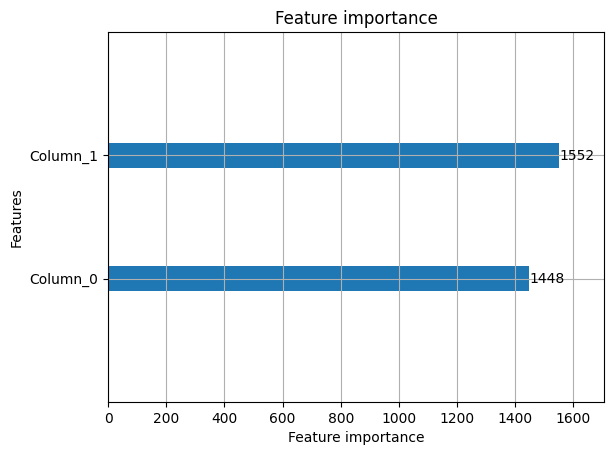

In [ ]:
import matplotlib.pyplot as plt

# Access the first regressor in the MultiOutputRegressor
regressor = multi_model.estimators_[0]

# Plot the feature importances
lgb.plot_importance(regressor)
plt.show()

<Axes: >

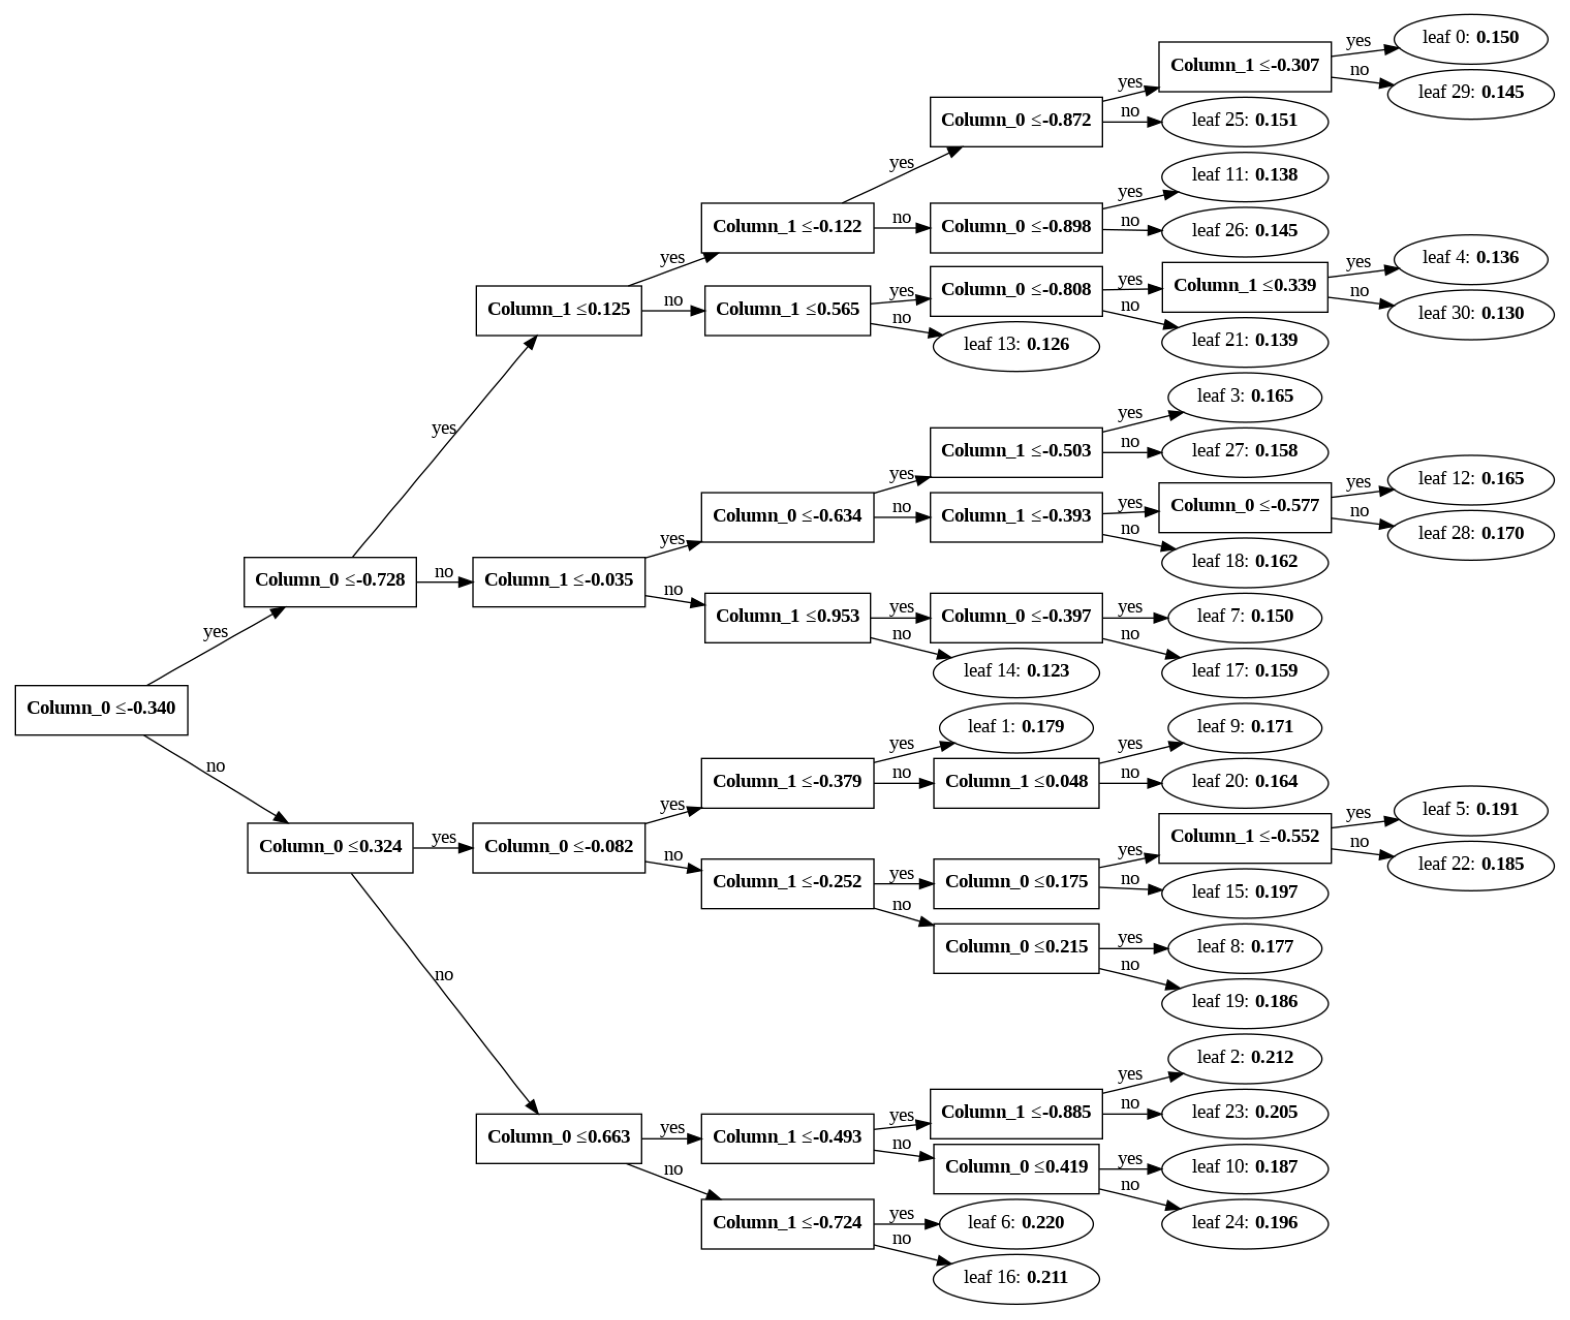

In [ ]:
# @title Plot tree
!pip install graphviz
import graphviz
lgb.plot_tree(multi_model.estimators_[0], figsize=(20, 20))


In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['Motor7_rad_pred', 'Motor8_rad_pred'])
y_test_plot['time'] = y_test.index

combined_df = pd.concat([y_test_plot.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)
combined_df["error"] = abs(combined_df["Motor7_rad"] - combined_df["Motor7_rad_pred"])
combined_df

Motor7_rad  Motor8_rad   time  Motor7_rad_pred  Motor8_rad_pred  \
0        0.606583   -0.000005  25744         0.605470         0.000049   
1        0.399996    0.073881   7675         0.402843         0.083804   
2        0.093205   -0.105206  30679         0.079199        -0.116391   
3       -0.000080   -0.018104  43665         0.004779        -0.076054   
4       -0.354445   -0.709045  14976        -0.363377        -0.713096   
...           ...         ...    ...              ...              ...   
14158    0.276069   -0.374371  44651         0.273208        -0.391681   
14159    0.354440   -0.354499  12497         0.356108        -0.347668   
14160    0.097040   -0.182331  20328         0.097164        -0.170359   
14161    0.534289   -0.056837  45947         0.532345        -0.073328   
14162    0.280228    0.141813  28641         0.225772         0.036990   

          error  
0      0.001113  
1      0.002847  
2      0.014007  
3      0.004858  
4      0.008932  
...         ...  
14158  0.002860  
14159  0.001668  
14160  0.000124  
14161  0.001944  
14162  0.054457  

[14163 rows x 6 columns]

In [ ]:
# @title Motor7_pred and Motor7 real vs time || Motor8_pred and Motor8 real vs time
# Call the function for Motor7
create_scatter_plot(
    df=combined_df,
    motor_pred_col='Motor7_rad_pred',
    motor_actual_col='Motor7_rad',
    motor_name='Motor7_rad',
    title='Comparation: Motor7_rad_pred vs Motor7_rad with Gradient Boosting')

# Call the function for Motor8
create_scatter_plot(
    df=combined_df,
    motor_pred_col='Motor8_rad_pred',
    motor_actual_col='Motor8_rad',
    motor_name='Motor8_rad',
    title='Comparation: Motor8_rad_pred vs Motor8_rad with Gradient Boosting')

In [ ]:
# @title Motor7_pred vs Motor7 || Motor8_pred vs Motor8
create_comparison_scatter_plot(combined_df, 'Motor7_rad', 'Motor7_rad_pred', 'Motor7', 'Motor7_pred vs Motor7 Comparison')
create_comparison_scatter_plot(combined_df, 'Motor8_rad', 'Motor8_rad_pred', 'Motor8', 'Motor8_pred vs Motor8 Comparison')

In [ ]:
# @title normal error at each time
import plotly.graph_objects as go

# Create the scatter plot for Motor7_rad_pred
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=combined_df['time'],
    y=combined_df['error'],
    mode='markers',
    marker=dict(size=8, color='red', opacity=0.8),
    name='Error',
    hovertemplate='Time: %{x}<br>error: %{y}'
))

# Customize the layout
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='error',
    showlegend=True,
    legend=dict(x=0.8, y=1),
    margin=dict(l=0, r=0, t=20, b=20),
    plot_bgcolor='white'
)

# Remove the top and right spines
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
# Show the plot
fig.show()

## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train) #train

y_pred = model.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)

print("Motor 7 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

print("\nMotor 8 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')

# # Save
# joblib.dump(model, 'trained_RandomForest_cleaned.pkl')
# joblib.dump(scaler, 'scaler_cleaned.pkl')

['scaler_cleaned.pkl']

## **K-Nearest Neighbors Regressor(KNR)**

In [ ]:
# K-Nearest Neighbors (KNR):
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve, cross_val_score

# Initialize the model
model = KNeighborsRegressor(n_neighbors=100) # best k=100
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)

print("Motor 7 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

print("\nMotor 8 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='r')
plt.plot(train_sizes, test_mean, label='Test score', color='g')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)

plt.xlabel('Number of training samples')
plt.ylabel('Score')
plt.title('Learning Curve for K-Nearest Neighbors (KNN)')
plt.legend()
plt.show()

# # Save
# joblib.dump(model, 'trained_KNeighbors_cleaned.pkl')
# joblib.dump(scaler, 'scaler_cleaned.pkl')  # También guardar el scaler para normalizar futuras entradas

['scaler_cleaned.pkl']

## **Constant Neural Networks with ELU**

Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1181/1181 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9049 - loss: 0.0148
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9494 - loss: 0.0010
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9496 - loss: 9.1666e-04
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9494 - loss: 8.9003e-04
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9513 - loss: 8.3019e-04
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9494 - loss: 8.7201e-04
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9498 - loss: 8.6350e-04
Epoch 8/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9520 - loss: 8.1039e-04
Epoch 9/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9513 - loss: 8.2075e-04
Succesfully trained
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9490 - loss: 8.1843e-04
Test Dataset accuracy: 0.95
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Motor 7 Errors:
Mean Sq

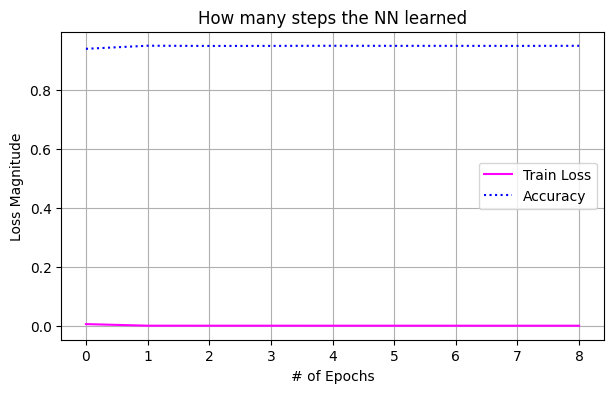

In [ ]:
neuronas=20

h_layer_1 = tf.keras.layers.Dense(units=neuronas, input_shape=[2], activation=tf.nn.elu, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_3 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_4 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_5 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_5 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2, activation=tf.nn.elu)

# Add the layers to the model, including the Dropout layers
model1 = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    h_layer_5, dropout_5,
    output
])

model1.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)
# training
print("Initializing training ...")
trained_model1 = model1.fit(X_train, y_train, epochs=15, callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")

#Loss Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.title("How many steps the NN learned")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Loss Magnitude')
plt.plot(trained_model1.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model1.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model1.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

# Predictions
y_pred = model1.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)


# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')


In [ ]:
# # Saving the model
# import joblib
# joblib.dump(model1, 'trained_model1_elu.pkl')

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['Motor7_rad_pred', 'Motor8_rad_pred'])
y_test_plot['time'] = y_test.index

combined_df = pd.concat([y_test_plot.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)
combined_df["error"] = abs(combined_df["Motor7_rad"] - combined_df["Motor7_rad_pred"])
combined_df

Motor7_rad  Motor8_rad   time  Motor7_rad_pred  Motor8_rad_pred  \
0       0.364810   -0.194038   9980         0.371221        -0.230529   
1       0.071426   -0.066648   1405         0.067984        -0.097016   
2       0.567530    0.283621  10958         0.573969         0.216546   
3       0.217293   -0.049253   4524         0.221295        -0.051831   
4       0.558465    0.194022  27875         0.560256         0.216002   
...          ...         ...    ...              ...              ...   
9437   -0.000213   -0.245586  17974        -0.009797        -0.297743   
9438    0.140205    0.048501  27376         0.124308         0.019978   
9439    0.048517   -0.091144   1107         0.047197        -0.134958   
9440    0.184094    0.027628  31552         0.154325         0.040370   
9441    0.283989    0.141851   5325         0.286025         0.109430   

         error  
0     0.006410  
1     0.003441  
2     0.006438  
3     0.004003  
4     0.001791  
...        ...  
9437  0.009584  
9438  0.015896  
9439  0.001321  
9440  0.029769  
9441  0.002036  

[9442 rows x 6 columns]

In [ ]:
# @title Motor7_pred and Motor7 real vs time || Motor8_pred and Motor8 real vs time
create_scatter_plot(df=combined_df, motor_pred_col='Motor7_rad_pred', motor_actual_col='Motor7_rad', motor_name='Motor7_rad', title='Comparation: Motor7_rad_pred vs Motor7_rad with Constant neural network')
create_scatter_plot( df=combined_df, motor_pred_col='Motor8_rad_pred', motor_actual_col='Motor8_rad', motor_name='Motor8_rad', title='Comparation: Motor8_rad_pred vs Motor8_rad with Constant neural network')

In [ ]:
# @title Motor7_pred vs Motor7 || Motor8_pred vs Motor8
create_comparison_scatter_plot(combined_df, 'Motor7_rad', 'Motor7_rad_pred', 'Motor7', 'Motor7_pred vs Motor7 Comparison')
create_comparison_scatter_plot(combined_df, 'Motor8_rad', 'Motor8_rad_pred', 'Motor8', 'Motor8_pred vs Motor8 Comparison')

Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1181/1181 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9355 - loss: 0.0210
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9492 - loss: 0.0010
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9479 - loss: 9.2146e-04
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9509 - loss: 9.3138e-04
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9502 - loss: 9.2842e-04
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9510 - loss: 9.2999e-04
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9496 - loss: 9.0769e-04
Succesfully trained
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9489 - loss: 0.0012
Test Dataset accuracy: 0.95
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Motor 7 Errors:
Mean Squared Error (MSE): 0.003926751019657886
R-squared (R2): 0.9352897897434868
Normalized Root Mean Squared Error (NRMSE): 0.055805026276983104
Normalized Mean Absolute Error (NMAE): 0.0429002

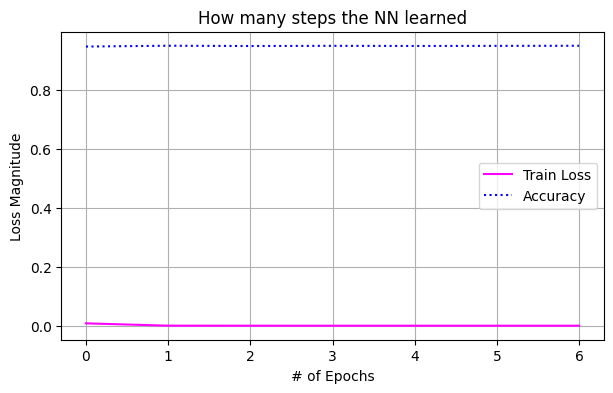

In [ ]:
neuronas = 20

h_layer_1 = tf.keras.layers.Dense(units=neuronas, input_shape=[2], activation=tf.nn.elu,  kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0.0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_3 = tf.keras.layers.Dropout(rate=0.0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_4 = tf.keras.layers.Dropout(rate=0.0)  # Add Dropout layer
h_layer_5 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_5 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_6 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_6 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_7 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_7 = tf.keras.layers.Dropout(rate=0.0)  # Add Dropout layer
h_layer_8 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_8 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_9 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_9 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_10 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_10 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2, activation=tf.nn.elu)

# Add the layers to the model, including the Dropout layers
model2 = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    h_layer_5, dropout_5,
    h_layer_6, dropout_6,
    h_layer_7, dropout_7,
    h_layer_8, dropout_8,
    h_layer_9, dropout_9,
    h_layer_10, dropout_10,
    output
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)

# training
print("Initializing training ...")
trained_model2 = model2.fit(X_train, y_train, epochs=15,callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")

#Loss Curve (que tan mal están los resultados de la red, en cada vuelta que dió)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.title("How many steps the NN learned")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Loss Magnitude')
plt.plot(trained_model2.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model2.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model2.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model2.predict(X_test)
mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)

# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')


In [ ]:
# # Saving the model
# import joblib
# joblib.dump(model2, 'trained_model2_elu.pkl')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Initializing training ...
Epoch 1/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9060 - loss: 0.0184
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8876 - loss: 0.0018
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8704 - loss: 0.0016
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8541 - loss: 0.0015
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8844 - loss: 0.0013
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8927 - loss: 0.0013
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9064 - loss: 0.0013
Succesfully trained
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9490 - loss: 0.0013
Test Dataset accuracy: 0.95
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Motor 7 Errors:
R-squared (R2): 0.9360529107156939
Normalized Root Mean Squared Error (NRMSE): 0.055474998877799366
Normalized Mean Absolute Error (NMAE): 0.03853297883113943

Motor 8 Errors:
R

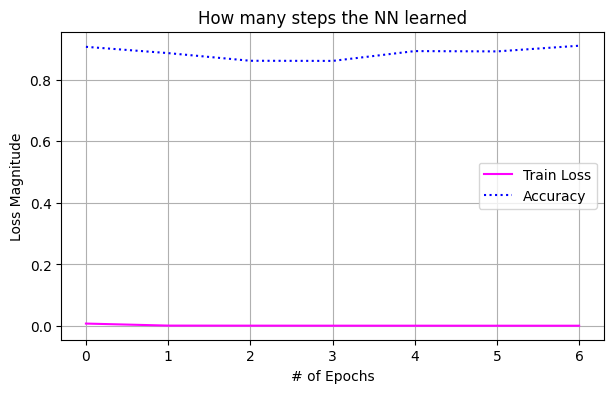

In [ ]:
neuronas = 20

h_layer_1 = tf.keras.layers.Dense(units=neuronas, input_shape=[2], activation=tf.nn.elu, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0.0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_3 = tf.keras.layers.Dropout(rate=0.2)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_4 = tf.keras.layers.Dropout(rate=0.0)  # Add Dropout layer
h_layer_5 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_5 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_6 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_6 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_7 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_7 = tf.keras.layers.Dropout(rate=0.0)  # Add Dropout layer
h_layer_8 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_8 = tf.keras.layers.Dropout(rate=0.2)  # Add Dropout layer
h_layer_9 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_9 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_10 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_10 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_11 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_11 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_12 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_12 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_13 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_13 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_14 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_14 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_15 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_15 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_16 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_16 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_17 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_17 = tf.keras.layers.Dropout(rate=0.2)  # Add Dropout layer
h_layer_18 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_18 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_19 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_19 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_20 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.elu)
dropout_20 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2, activation=tf.nn.elu)

# Add the layers to the model, including the Dropout layers
model3 = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    h_layer_5, dropout_5,
    h_layer_6, dropout_6,
    h_layer_7, dropout_7,
    h_layer_8, dropout_8,
    h_layer_9, dropout_9,
    h_layer_10, dropout_10,
    h_layer_11, dropout_11,
    h_layer_12, dropout_12,
    h_layer_13, dropout_13,
    h_layer_14, dropout_14,
    h_layer_15, dropout_15,
    h_layer_16, dropout_16,
    h_layer_17, dropout_17,
    h_layer_18, dropout_18,
    h_layer_19, dropout_19,
    h_layer_20, dropout_20,
    output
])

model3.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)

# training
print("Initializing training ...")
trained_model3 = model3.fit(X_train, y_train, epochs=15, callbacks = early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")

#Loss Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.title("How many steps the NN learned")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Loss Magnitude')
plt.plot(trained_model3.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model3.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model3.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model3.predict(X_test)
mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)

# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
#print(f'Relative Absolute Error (RAE): {rae_motor7}')
#print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
#print(f'Relative Absolute Error (RAE): {rae_motor8}')
#print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')

## **Neural Networks with TANH**

Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1181/1181 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9171 - loss: 0.0121
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9504 - loss: 0.0010
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9486 - loss: 9.4489e-04
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9509 - loss: 8.8977e-04
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9500 - loss: 9.2074e-04
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9500 - loss: 8.5597e-04
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9513 - loss: 8.6606e-04
Succesfully trained
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9479 - loss: 9.5832e-04
Test Dataset accuracy: 0.95
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<ipython-input-7-ae8b55564421>:32: RuntimeWarning:

invalid value encountered in log1p



Motor 7 Errors:
R-squared (R2): 0.9556190614066283
Normalized Root Mean Squared Error (NRMSE): 0.04621523363004144
Normalized Mean Absolute Error (NMAE): 0.029041690678519007

Motor 8 Errors:
R-squared (R2): 0.44828402503218545
Normalized Root Mean Squared Error (NRMSE): 0.16422432047377655
Normalized Mean Absolute Error (NMAE): 0.11686044746418832


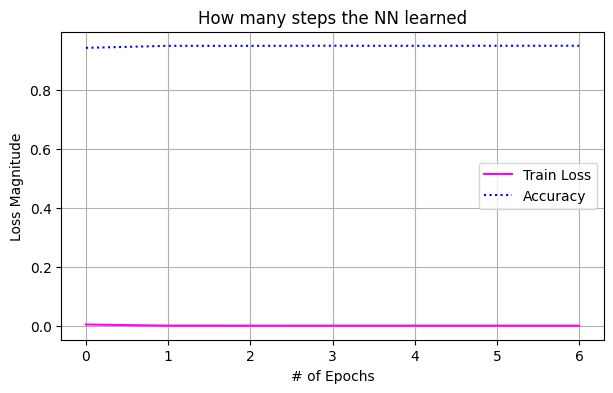

In [ ]:
neuronas=20

h_layer_1 = tf.keras.layers.Dense(units=neuronas, input_shape=[2], activation=tf.nn.tanh, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.tanh)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.tanh)
dropout_3 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.tanh)
dropout_4 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_5 = tf.keras.layers.Dense(units=neuronas, activation=tf.nn.tanh)
dropout_5 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2)

# Add the layers to the model, including the Dropout layers
model1_tanh = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    h_layer_5, dropout_5,
    output
])

model1_tanh.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)
# training
print("Initializing training ...")
trained_model1_tanh = model1_tanh.fit(X_train, y_train, epochs=15, callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")

#Loss Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.title("How many steps the NN learned")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Loss Magnitude')
plt.plot(trained_model1_tanh.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model1_tanh.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model1_tanh.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model1_tanh.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)


# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
#print(f'Relative Absolute Error (RAE): {rae_motor7}')
#print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
#print(f'Relative Absolute Error (RAE): {rae_motor8}')
#print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')

In [ ]:
# Saving the model
import joblib
joblib.dump(model1_tanh, 'trained_model1_tanh.pkl')

## **Symmetric Neural Networks with ELU**

Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1181/1181 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8958 - loss: 0.0198
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9512 - loss: 0.0011
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9512 - loss: 9.0006e-04
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9512 - loss: 8.5347e-04
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9510 - loss: 8.3252e-04
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9516 - loss: 8.1877e-04
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9514 - loss: 8.0991e-04
Succesfully trained
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9479 - loss: 0.0013
Test Dataset accuracy: 0.95
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Motor 7 Errors:
R-squared (R2): 0.9282163822955347
Normalized Root Mean Squared Error (NRMSE): 0.05877593985427485
Normalized Mean Absolute Error (NMAE): 0.032953842280178856
Relative Absolute Error (RAE): 0.181

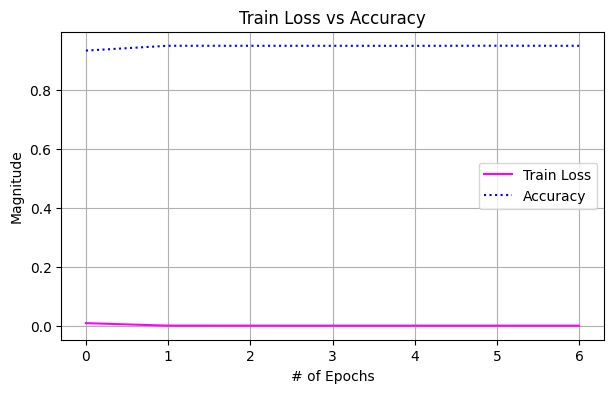

In [ ]:
# semillas
np.random.seed(42)  # Semilla para NumPy
random.seed(42)  # Semilla para Python
tf.random.set_seed(42)  # Semilla para TensorFlow

h_layer_1 = tf.keras.layers.Dense(units=5, input_shape=[2], activation=tf.nn.elu, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=15, activation=tf.nn.elu)
dropout_3 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_4 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_5 = tf.keras.layers.Dense(units=5, activation=tf.nn.elu)
dropout_5 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2)

# Add the layers to the model, including the Dropout layers
model4 = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    h_layer_5, dropout_5,
    output
])

model4.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)
# training
print("Initializing training ...")
trained_model4 = model4.fit(X_train, y_train, epochs=15, callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")


#Train Loss Curve vs Accuracy
plt.figure(figsize=(7,4))
plt.title("Train Loss vs Accuracy")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Magnitude')
plt.plot(trained_model4.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model4.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model4.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model4.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)
# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')

In [ ]:
# Saving the model
# import joblib
# joblib.dump(model4, 'trained_model4_elu.pkl')


Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1181/1181 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8665 - loss: 0.0086
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7774 - loss: 0.0030
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7803 - loss: 0.0030
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7866 - loss: 0.0030
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7929 - loss: 0.0030
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8017 - loss: 0.0030
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8109 - loss: 0.0030
Epoch 8/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8246 - loss: 0.0030
Epoch 9/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8375 - loss: 0.0030
Epoch 10/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8701 - loss: 0.0030
Epoch 11/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9414 - loss: 0.0030
Epoch 12/15
1181/1181 ━━━━━━━━━━━━━━━━━━━

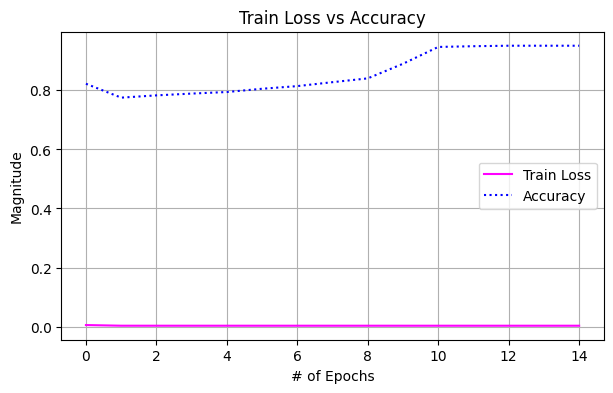

In [ ]:
h_layer_1 = tf.keras.layers.Dense(units=5, input_shape=[2], activation=tf.nn.elu, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=15, activation=tf.nn.elu)
dropout_3 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=20, activation=tf.nn.elu)
dropout_4 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_5 = tf.keras.layers.Dense(units=15, activation=tf.nn.elu)
dropout_5 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_6 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_6 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_7 = tf.keras.layers.Dense(units=5, activation=tf.nn.elu)
dropout_7 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2)

# Add the layers to the model, including the Dropout layers
model5 = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    h_layer_5, dropout_5,
    h_layer_6, dropout_6,
    h_layer_7, dropout_7,
    output
])

model5.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)
# training
print("Initializing training ...")
trained_model5 = model5.fit(X_train, y_train, epochs=15, callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")


#Train Loss Curve vs Accuracy
plt.figure(figsize=(7,4))
plt.title("Train Loss vs Accuracy")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Magnitude')
plt.plot(trained_model5.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model5.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model5.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model5.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)
# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')


In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['Motor7_rad_pred', 'Motor8_rad_pred'])
y_test_plot['time'] = y_test.index

combined_df = pd.concat([y_test_plot.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)
combined_df["error"] = abs(combined_df["Motor7_rad"] - combined_df["Motor7_rad_pred"])
combined_df
# @title Motor7_pred and Motor7 real vs time || Motor8_pred and Motor8 real vs time
create_scatter_plot(df=combined_df, motor_pred_col='Motor7_rad_pred', motor_actual_col='Motor7_rad', motor_name='Motor7_rad', title='Comparation: Motor7_rad_pred vs Motor7_rad with Gradient Boosting')
create_scatter_plot( df=combined_df, motor_pred_col='Motor8_rad_pred', motor_actual_col='Motor8_rad', motor_name='Motor8_rad', title='Comparation: Motor8_rad_pred vs Motor8_rad with Gradient Boosting')

Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1181/1181 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9393 - loss: 0.0216
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9508 - loss: 0.0011
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9507 - loss: 8.8621e-04
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9507 - loss: 8.4486e-04
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9504 - loss: 8.3363e-04
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9507 - loss: 8.3281e-04
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9509 - loss: 8.2627e-04
Succesfully trained
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9479 - loss: 0.0013
Test Dataset accuracy: 0.95
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Motor 7 Errors:
R-squared (R2): 0.9330821340147687
Normalized Root Mean Squared Error (NRMSE): 0.056748966010972825
Normalized Mean Absolute Error (NMAE): 0.029189971716356344

Motor 8 Errors:
R-squared (R2): 0.

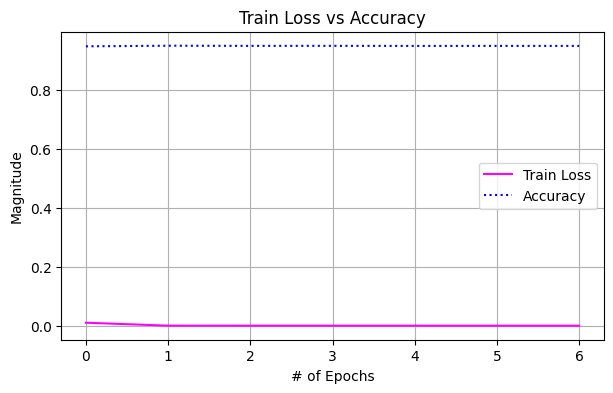

In [ ]:
h_layer_1 = tf.keras.layers.Dense(units=5, input_shape=[2], activation=tf.nn.elu, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=15, activation=tf.nn.elu)
dropout_3 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=20, activation=tf.nn.elu)
dropout_4 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_5 = tf.keras.layers.Dense(units=25, activation=tf.nn.elu)
dropout_5 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_6 = tf.keras.layers.Dense(units=20, activation=tf.nn.elu)
dropout_6 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_7 = tf.keras.layers.Dense(units=15, activation=tf.nn.elu)
dropout_7 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_8 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_8 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_9 = tf.keras.layers.Dense(units=5, activation=tf.nn.elu)
dropout_9 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2)

# Add the layers to the model, including the Dropout layers
model6 = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    h_layer_5, dropout_5,
    h_layer_6, dropout_6,
    h_layer_7, dropout_7,
    h_layer_8, dropout_8,
    h_layer_9, dropout_9,
    output
])

model6.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)
# training
print("Initializing training ...")
trained_model6= model6.fit(X_train, y_train, epochs=15, callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")


#Train Loss Curve vs Accuracy
plt.figure(figsize=(7,4))
plt.title("Train Loss vs Accuracy")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Magnitude')
plt.plot(trained_model6.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model6.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model6.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model6.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)
# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
#print(f'Relative Absolute Error (RAE): {rae_motor7}')
#print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
#print(f'Relative Absolute Error (RAE): {rae_motor8}')
#print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')


In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['Motor7_rad_pred', 'Motor8_rad_pred'])
y_test_plot['time'] = y_test.index

combined_df = pd.concat([y_test_plot.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)
combined_df["error"] = abs(combined_df["Motor7_rad"] - combined_df["Motor7_rad_pred"])
combined_df
# @title Motor7_pred and Motor7 real vs time || Motor8_pred and Motor8 real vs time
create_scatter_plot(df=combined_df, motor_pred_col='Motor7_rad_pred', motor_actual_col='Motor7_rad', motor_name='Motor7_rad', title='Comparation: Motor7_rad_pred vs Motor7_rad with Gradient Boosting')
create_scatter_plot( df=combined_df, motor_pred_col='Motor8_rad_pred', motor_actual_col='Motor8_rad', motor_name='Motor8_rad', title='Comparation: Motor8_rad_pred vs Motor8_rad with Gradient Boosting')

## **Symmetric Neural Networks with TANH**


Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1181/1181 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3918 - loss: 0.0449
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5710 - loss: 0.0282
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6139 - loss: 0.0280
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6216 - loss: 0.0280
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6254 - loss: 0.0280
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6290 - loss: 0.0280
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6294 - loss: 0.0280
Epoch 8/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6332 - loss: 0.0280
Epoch 9/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6341 - loss: 0.0280
Epoch 10/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6383 - loss: 0.0280
Epoch 11/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6388 - loss: 0.0280
Epoch 12/15
1181/1181 ━━━━━━━━━━━━━━━━━━━

<ipython-input-7-ae8b55564421>:32: RuntimeWarning:

invalid value encountered in log1p



Motor 7 Errors:
R-squared (R2): -0.9802642882168211
Normalized Root Mean Squared Error (NRMSE): 0.30870843014785654
Normalized Mean Absolute Error (NMAE): 0.2415254406759583
Relative Absolute Error (RAE): 1.3320230419524206
Mean Squared Logarithmic Error (MSLE): 0.08986256659119342

Motor 8 Errors:
R-squared (R2): 0.48192808354790384
Normalized Root Mean Squared Error (NRMSE): 0.15913830181075833
Normalized Mean Absolute Error (NMAE): 0.11782563952381847
Relative Absolute Error (RAE): 0.6495587222670464
Mean Squared Logarithmic Error (MSLE): nan


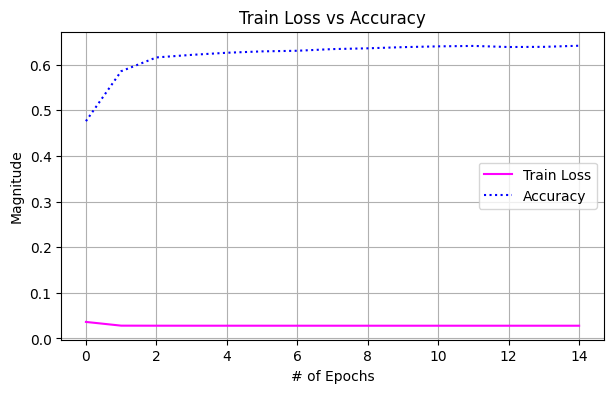

In [ ]:
# Establecer las semillas para reproducibilidad
np.random.seed(42)  # Semilla para NumPy
random.seed(42)  # Semilla para Python
tf.random.set_seed(42)  # Semilla para TensorFlow

h_layer_1 = tf.keras.layers.Dense(units=5, input_shape=[2], activation=tf.nn.tanh, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=10, activation=tf.nn.tanh)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=15, activation=tf.nn.tanh)
dropout_3 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=10, activation=tf.nn.tanh)
dropout_4 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_5 = tf.keras.layers.Dense(units=5, activation=tf.nn.tanh)
dropout_5 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2)

# Add the layers to the model, including the Dropout layers
model4_tanh = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    h_layer_5, dropout_5,
    output
])

model4_tanh.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)
# training
print("Initializing training ...")
trained_model4_tanh = model4_tanh.fit(X_train, y_train, epochs=15, callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")

#Train Loss Curve vs Accuracy
plt.figure(figsize=(7,4))
plt.title("Train Loss vs Accuracy")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Magnitude')
plt.plot(trained_model4_tanh.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model4_tanh.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model4_tanh.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model4_tanh.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)
# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')

## **Alternating Neural Networks with ELU**

Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7593 - loss: 0.0217
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8233 - loss: 0.0031
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8191 - loss: 0.0030
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8140 - loss: 0.0029
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8112 - loss: 0.0029
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8077 - loss: 0.0029
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8045 - loss: 0.0029
Succesfully trained
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7979 - loss: 0.0035
Test Dataset accuracy: 0.79
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Motor 7 Errors:
R-squared (R2): 0.9602079789207473
Normalized Root Mean Squared Error (NRMSE): 0.04409170300268218
Normalized Mean Absolute Error (NMAE): 0.027752034823304832
Relative Absolute Error (RAE): 0.15194901767034136
Mean 

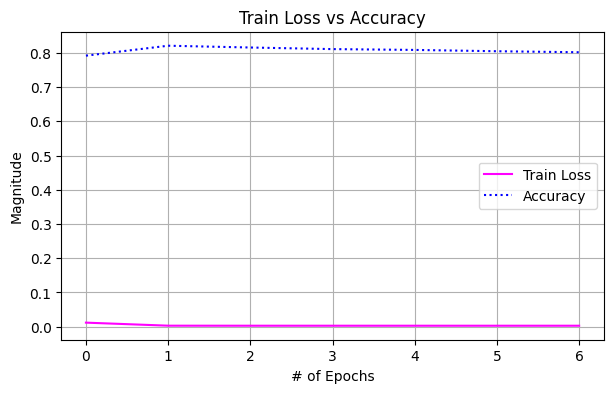

In [ ]:
h_layer_1 = tf.keras.layers.Dense(units=5, input_shape=[2], activation=tf.nn.elu, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=5, activation=tf.nn.elu)
dropout_3 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_4 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2)

# Add the layers to the model, including the Dropout layers
model7 = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    output
])

model7.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)
# training
print("Initializing training ...")
trained_model7 = model7.fit(X_train, y_train, epochs=15, callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")


#Train Loss Curve vs Accuracy
plt.figure(figsize=(7,4))
plt.title("Train Loss vs Accuracy")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Magnitude')
plt.plot(trained_model7.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model7.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model7.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model7.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)
# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')

In [ ]:
# Saving the model
import joblib
joblib.dump(model7, 'trained_model7_elu.pkl')

['trained_model7_elu_cleaned.pkl']

Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1181/1181 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8444 - loss: 0.0213
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8279 - loss: 0.0032
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8332 - loss: 0.0029
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8336 - loss: 0.0028
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8108 - loss: 0.0028
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7960 - loss: 0.0028
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7878 - loss: 0.0027
Epoch 8/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7708 - loss: 0.0027
Succesfully trained
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8400 - loss: 0.0020
Test Dataset accuracy: 0.84
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Motor 7 Errors:
R-squared (R2): 0.9578183090722533
Normalized Root Mean Squared Error (NRMSE): 0.04539634281818571
Normalized Mean Absolute Err

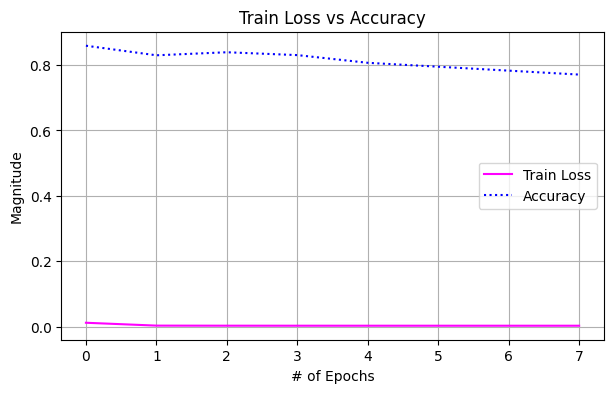

In [ ]:
h_layer_1 = tf.keras.layers.Dense(units=5, input_shape=[2], activation=tf.nn.elu, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0.3)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=5, activation=tf.nn.elu)
dropout_3 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_4 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_5 = tf.keras.layers.Dense(units=5, activation=tf.nn.elu)
dropout_5 = tf.keras.layers.Dropout(rate=0.2)  # Add Dropout layer
h_layer_6 = tf.keras.layers.Dense(units=10, activation=tf.nn.elu)
dropout_6 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2)

# Add the layers to the model, including the Dropout layers
model8 = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    h_layer_5, dropout_5,
    h_layer_6, dropout_6,
    output
])

model8.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)
# training
print("Initializing training ...")
trained_model8 = model8.fit(X_train, y_train, epochs=15, callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")

#Train Loss Curve vs Accuracy
plt.figure(figsize=(7,4))
plt.title("Train Loss vs Accuracy")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Magnitude')
plt.plot(trained_model8.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model8.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model8.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model8.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)
# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')

##**Alternating Neural Network with TANH**

Initializing training ...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8126 - loss: 0.0202
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7874 - loss: 0.0031
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7892 - loss: 0.0030
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7894 - loss: 0.0029
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7883 - loss: 0.0029
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7867 - loss: 0.0029
Epoch 7/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7845 - loss: 0.0029
Succesfully trained
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7716 - loss: 0.0034
Test Dataset accuracy: 0.77
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Motor 7 Errors:
R-squared (R2): 0.9596933662412248
Normalized Root Mean Squared Error (NRMSE): 0.04437589640321668
Normalized Mean Absolute Error (NMAE): 0.026339045210863103
Relative Absolute Error (RAE): 0.14421256212912026
Mean 

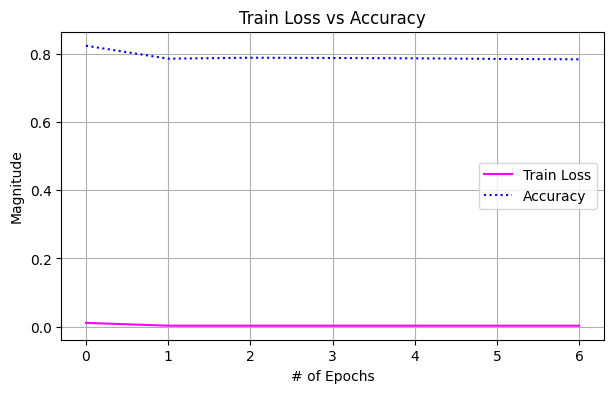

In [ ]:
# Establecer las semillas para reproducibilidad
np.random.seed(42)  # Semilla para NumPy
random.seed(42)  # Semilla para Python
tf.random.set_seed(42)  # Semilla para TensorFlow

h_layer_1 = tf.keras.layers.Dense(units=5, input_shape=[2], activation=tf.nn.tanh, kernel_regularizer=keras.regularizers.l2(0.01))
dropout_1 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_2 = tf.keras.layers.Dense(units=10, activation=tf.nn.tanh)
dropout_2 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_3 = tf.keras.layers.Dense(units=5, activation=tf.nn.tanh)
dropout_3 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
h_layer_4 = tf.keras.layers.Dense(units=10, activation=tf.nn.tanh)
dropout_4 = tf.keras.layers.Dropout(rate=0)  # Add Dropout layer
output = tf.keras.layers.Dense(units=2)

# Add the layers to the model, including the Dropout layers
model7_tanh = tf.keras.Sequential([
    h_layer_1, dropout_1,
    h_layer_2, dropout_2,
    h_layer_3, dropout_3,
    h_layer_4, dropout_4,
    output
])

model7_tanh.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    jit_compile = True
)
# training
print("Initializing training ...")
trained_model7_tanh = model7_tanh.fit(X_train, y_train, epochs=15, callbacks=early_stopping) #steps_per_epoch=math.ceil(), verbose=False
print("Succesfully trained")

#Train Loss Curve vs Accuracy
plt.figure(figsize=(7,4))
plt.title("Train Loss vs Accuracy")
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Magnitude')
plt.plot(trained_model7_tanh.history['loss'], color = 'fuchsia', label = 'Train Loss')
plt.plot(trained_model7_tanh.history['accuracy'], color = 'blue', label = 'Accuracy', linestyle=':')
plt.legend()

#Test model using testing dataset
test_loss, test_accuracy = model7_tanh.evaluate(X_test,y_test)
print('Test Dataset accuracy:', format(round(float(test_accuracy),2)))

y_pred = model7_tanh.predict(X_test)

mse_motor7, r2_motor7, nrmse_motor7, nmae_motor7, rae_motor7, msle_motor7, mse_motor8, r2_motor8, nrmse_motor8, nmae_motor8, rae_motor8, msle_motor8 = calculate_errors(y_test, y_pred)
# Imprimir los errores para el motor 7
print("Motor 7 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor7}')
print(f'R-squared (R2): {r2_motor7}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor7}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor7}')
print(f'Relative Absolute Error (RAE): {rae_motor7}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor7}')

# Imprimir los errores para el motor 8
print("\nMotor 8 Errors:")
#print(f'Mean Squared Error (MSE): {mse_motor8}')
print(f'R-squared (R2): {r2_motor8}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse_motor8}')
print(f'Normalized Mean Absolute Error (NMAE): {nmae_motor8}')
print(f'Relative Absolute Error (RAE): {rae_motor8}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_motor8}')